In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [2]:
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [3]:
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [4]:
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [1]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [1]}]


In [5]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


In [6]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


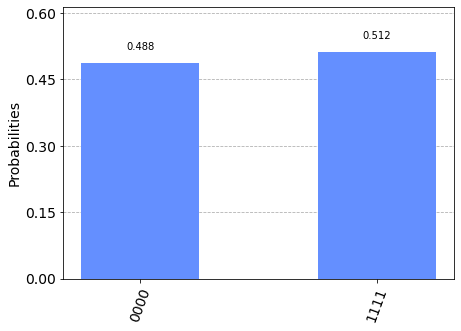

In [7]:
#Perfect QC
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

In [8]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1 #Might Measure Wrong Value
p_gate1 = 0.05 #Gate might not Work

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'cx', 'measure', 'u1', 'u3']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


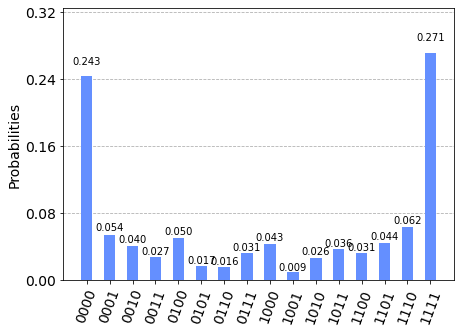

In [10]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [ ]:
#Shor Code -> Mitigate Error? 